# Modal Analysis - Thermal Transport

## 1. Introduction
- In this tutorial, we use the SHC, HNEMA, and GKMA methods to study heat transport in hBN at 300 K. There are six parts to this tutorial:
> - Introduction
> - Structure creation
> - Eigenvector calculation
> - HNEMA Simulations
> - GKMA Simulations
> - References
- This example is based on the work described in [[Gabourie 2021](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.103.205421)].
- Note that this tutorial is simplified to demonstrate how to use [gpyumd](https://github.com/AlexGabourie/gpyumd) and a real investigation of the thermal properties of hBN requires significantly more simulations.  

### Importing Relevant Functions
- The inputs/outputs for GPUMD are processed using the [Atomic Simulation Environment (ASE)](https://wiki.fysik.dtu.dk/ase/) and the [gpyumd](https://github.com/AlexGabourie/gpyumd) package.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from ase.build import graphene_nanoribbon
from ase import Atom
from gpyumd.atoms import GpumdAtoms
from gpyumd.sim import Simulation
import gpyumd.keyword as kwd
from gpyumd.load import load_frequency_info, load_kappa, load_kappamode, \
                        load_shc, load_hac, load_heatmode, load_saved_heatmode
from gpyumd.math import running_ave
from gpyumd.calc import calc_spectral_kappa, calc_gkma_kappa

eigen_dir = 'eigenvector'
hnema_dir = 'hnema'
gkma_dir = 'gkma'

### Figure Properties

In [2]:
aw = 2
fs = 16
font = {'size'   : fs}
plt.rc('font', **font)
plt.rc('axes' , linewidth=aw)

def set_fig_properties(ax_list):
    ax_list = ax_list if isinstance(ax_list, list) else [ax_list]
    tl = 8
    tw = 2
    tlm = 4
    
    for ax in ax_list:
        ax.tick_params(which='major', length=tl, width=tw)
        ax.tick_params(which='minor', length=tlm, width=tw)
        ax.tick_params(which='both', axis='both', direction='in', right=True, top=True)

## 2. Structure Creation
- The structure is a 3840 atom hBN structure that is ~10 $\times$ 10 nm<sup>2</sup>. To create this, we generate a graphene nanoribbon, but swap carbon with boron. We then change half the masses to that of nitrogen, but keep the type as boron. We keep the type as boron because the Tersoff potential [[Tersoff 1989]](https://doi.org/10.1103/PhysRevB.39.5566) we use for hBN [[Sevik 2011]](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.84.085409) does not have parameters that are distinguished by type (i.e., it is a one atom potential). This mass changing trick is OK here, but, a simple change to the hBN potential file (i.e., from a one atom to a two atom potential) would be needed if your simulation also used an LJ potential as the type becomes important.
- The thickness of the hBN sheet is 3.33 $\mathring A$ and this is used to calculate the thermal conductivity.

In [3]:
hbn = GpumdAtoms(graphene_nanoribbon(40,24, type='armchair', sheet=True, 
                                     vacuum=3.33/2, main_element='B', C_C=1.44))
nitrogen_mass = Atom('N').mass
for i, atom in enumerate(hbn):
    if i % 2 == 1:
        atom.mass = nitrogen_mass
        
hbn.euler_rotate(theta=90)
lx, lz, ly = hbn.cell.lengths()
hbn.cell = hbn.cell.new((lx, ly, lz))
hbn.center()
hbn.pbc = [True, True, False]
hbn.set_cutoff(2.1)
hbn.set_max_neighbors(3)
hbn

GpumdAtoms(symbols='B3840', pbc=[True, True, False], cell=[99.76612651596731, 103.68, 3.33], masses=...)

- While we generate the [xyz.in](https://gpumd.zheyongfan.org/index.php/The_xyz.in_input_file) file later when we create a simulation, we'll show the first few lines of what it will look like here:
```
3840 3 2.1 0 0 0
1 1 0 99.76612651596731 103.68 3.33
0 97.89551164379293 0.7199999999999991 1.664999999999997 10.81
0 99.14258822524252 1.439999999999999 1.664999999999997 14.007
0 99.14258822524252 2.879999999999999 1.6649999999999971 10.81
0 97.89551164379293 3.5999999999999988 1.6649999999999971 14.007
```

- Explanations for the first line:
  - The first number states that the number of particles is 3840.
  - The second number in this line, 3, is good for hBN described by the Tersoff potential because no atom can have more than 3 neighbor atoms at room temperature. Making this number larger only results in more memory usage. If this number is not large enough, GPUMD will give an error message and exit.
  - The next number, 2.1, means that the initial cutoff distance for the neighbor list construction is 2.1 A. Here, we only need to consider the first nearest neighbors. Any number larger than the first nearest neighbor distance and smaller than the second nearest neighbor distance is OK here. Note that we will also not update the neighbor list. There is no such need in this problem. 
  - The remaining three zeros in the first line mean:
    - the box is orthogonal;
    - the initial velocities are not contained in this file;
    - there are no grouping methods defined here.


 - Explanations for the second line:
   - The numbers 1 1 0 mean that the x and y (in-plane) directions are periodic and the z direction is open (free).
   - The remaining three numbers are the box lengths in the three directions. The box length in a free direction is chosen based on some convention. This number will only affect the system volume.

- Starting from the third line, the numbers in the first column are all 0 here, which means that all the atoms are of type 0 (single atom-type system). The next three columns are the initial coordinates of the atoms. The last column gives the masses of the atoms. Remember that the hBN Tersoff potential [[Sevik 2011](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.84.085409)] we are using represents B and N atoms using the same parameters, so it is a single atom-type potential; however, we change the masses to reflect the correct type.


## 3. Eigenvector Calculation
- The eigenvectors of the structure serve as the basis on which we calculate the HNEMA and GKMA thermal condutivities. Each eigenvector corresponds to one vibrational mode.
- We must run a specific phonon calculation that outputs the [eigenvector.out](https://gpumd.zheyongfan.org/index.php/The_eigenvector.in_input_file) file which, with a simple name change to [eigenvector.in](https://gpumd.zheyongfan.org/index.php/The_eigenvector.in_input_file), becomes an input file for the GKMA and HNEMA calculations.

### Add Basis and $k$-Points
- To calculate the eigenvectors of the system, we need to first run a phonon calculation. The modal analysis methods treat the entire structure as a unit cell, so each atom gets a unique basis ID in the [basis.in](https://gpumd.zheyongfan.org/index.php/The_basis.in_input_file) file and only one $k$-point is required in the [kpoints.in](https://gpumd.zheyongfan.org/index.php/The_kpoints.in_input_file) file.

In [4]:
hbn.add_basis()
hbn.write_basis(directory=eigen_dir)
linear_path, sym_points, labels = hbn.write_kpoints(path='G',npoints=1, directory=eigen_dir)

- The first few lines of the <code>basis.in</code> file will look like:
```
3840
0 10.81
1 14.007
2 10.81
3 14.007
...
```
and the entirety of the <code>kpoints.in</code> file will look like:
```
1
0 0 0
```
To run the GKMA and HNEMA simulations, it is essential that the <code>basis.in</code> and <code>kpoints.in</code> files are formatted this way. Specifically, the single $k$-point at the $\Gamma$-point tells GPUMD to generate the [eigenvector.out](https://gpumd.zheyongfan.org/index.php/The_eigenvector.in_input_file) file, which is a required input to GKMA and HNEMA calculations.

### The <code>run.in</code> file
The [gpyumd](https://github.com/AlexGabourie/gpyumd) package can be used to generate valid <code>run.in</code> input files as well as other necessary input files. It follows the definitions described in the [inputs and outputs](https://gpumd.zheyongfan.org/index.php/Main_Page#Inputs_and_outputs_for_GPUMD) documentation for <code>GPUMD</code>.
- Note that the simulation files will be generated in or moved to the 'eigenvector' folder as defined in the `eig_sim` Simulation object. 

In [5]:
eig_sim = Simulation(hbn, driver_directory='.', run_directory=eigen_dir)
eig_sim.add_static_calc(kwd.Minimize(force_tolerance=1e-8, max_iterations=10000))
eig_sim.add_static_calc(kwd.ComputePhonon(cutoff=4, displacement=0.005))
potential_directory = "/path/to/GPUMD/potentials/tersoff"
tersoff_potential = \
    kwd.Potential(filename='BN_Sevik_2011.txt', symbols=['B'], directory=potential_directory)
eig_sim.add_potential(tersoff_potential)
eig_sim.create_simulation(copy_potentials=True)

The <code>run.in</code> input file is given below:
```
potential eigenvector/BN_Sevik_2011.txt 0

minimize sd 1e-08 10000
compute_phonon 4 0.005
```
- The first line with the [potential](https://gpumd.zheyongfan.org/index.php/The_potential_keyword) keyword states that the potential to be used is specified in the file [BN_Sevik_2011.txt](https://github.com/brucefan1983/GPUMD/blob/master/potentials/tersoff/BN_Sevik_2011.txt).
- The second line with the [minimize](https://gpumd.zheyongfan.org/index.php/The_minimize_keyword) keyword states that the energy of the system will be minimized using the steepest descent algorithm until either the forces are smaller than 1.0e-8 ev/$\mathring A$ or 10000 minimization steps have been completed.
- The third line with the [compute_phonon](https://gpumd.zheyongfan.org/index.php/The_compute_phonon_keyword) keyword tells that the force constants will be calculated with a cutoff of 4.0 $\mathring A$ (here the point is that first and second nearest neighbors need to be included) and a displacement of 0.005 $\mathring A$ will be used in the finite-displacement method.

### The <code>eigenvector.in</code> file
- With the $\Gamma$-point phonon calculation, GPUMD will output the [eigenvector.out](https://gpumd.zheyongfan.org/index.php/The_eigenvector.in_input_file) file. As all input files to GPUMD have the file type <code>.in</code>, a simple file type change to <code>.in</code> is all that is needed to prepare it for an HNEMA and GKMA calculation.
- We can explore the vibrational modes of the system using the <code>load_frequency_info</code> function from [gpyumd](https://github.com/AlexGabourie/gpyumd). This will help us choose which vibrational mode binning options we want in the GKMA and HNEMA calculations.

In [6]:
freq = load_frequency_info(num_atoms=len(hbn), bin_f_size=1, directory=eigen_dir)
freq.keys()

dict_keys(['fq', 'fmax', 'fmin', 'shift', 'nbins', 'bin_count', 'bin_f_size'])

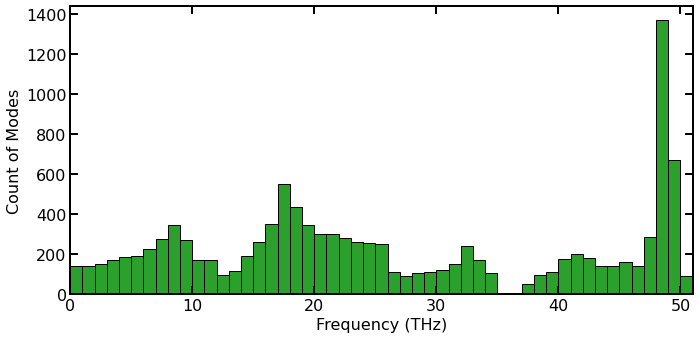

In [7]:
flow = freq['fmin'] + freq['bin_f_size']/2
fhigh = freq['fmax']-freq['bin_f_size']/2

plt.figure(figsize=(10,5))
counts, bins, bars = plt.hist(abs(freq['fq']), freq['nbins'], range=(freq['fmin'], freq['fmax']),edgecolor='k', color='C2')
set_fig_properties([plt.gca()])
plt.ylabel('Count of Modes')
plt.xlabel('Frequency (THz)')
plt.xlim([0, freq['nbins']])
plt.tight_layout()
plt.show()

Histogram of the count of vibrational frequencies from lattice dynamics (LD) calculations for hBN.

- The figure above gathers the vibrational modes of the hBN into bins that are 1 THz wide. While not shown here, this distribution should correspond nicely with a [VDOS](https://gpumd.zheyongfan.org/index.php/The_compute_dos_keyword) calculation [[Gabourie 2021]](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.103.205421).
- The bins shown here also correspond to how GPUMD will bin the eigenvectors for the GKMA and HNEMA calculations if using the <code>f_bin_size</code> option. The thermal conductivity will be binned the same as well. This means that, for example, in the 0 THz to 1 THz range, there will be 143 modal thermal conductivity calculations that contribute to the bar in that frequency range of the histogram.
- While the HNEMA and GKMA calculations consider each eigenvector (vibrational mode) individually, binning the vibrational modes together can drastically reduce the number of simulations required to converge the spectral thermal conductivity; however, the user is trading-off the speed and resolution and must find a balance that works for them. We find 51 bins to provide enough spectral information for our purposes here.
- Note, for GKMA, binning will also significantly reduce output file sizes.


## 4. HNEMA Simulation
- The setup for an HNEMA simulation [[Gabourie 2021]](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.103.205421) is almost identical to that of an HNEMD simulation [[Fan 2019]](https://doi.org/10.1103/PhysRevB.99.064308). In fact, the [compute_hnemd](https://gpumd.zheyongfan.org/index.php/The_compute_hnemd_keyword) keyword can be run at the same time as the [compute_hnema](https://gpumd.zheyongfan.org/index.php/The_compute_hnema_keyword).

### The <code>run.in</code> file

In [8]:
# Variables we use for the simulation & processing
hnema_num_steps = 1e7
ydrive_force = 1e-5
hnema_output_interval = 1e4

In [9]:
hnema_sim = Simulation(hbn, driver_directory='.', run_directory=hnema_dir)
hnema_sim.add_static_calc(kwd.Minimize(force_tolerance=1e-8, max_iterations=1e4))

In [10]:
# equilibration simulation
header = "Heat Step (100 ps)"
curr_run = hnema_sim.add_run(number_of_steps=1e5, run_name='equilibration', run_header=header)

nvt_ensemble = kwd.Ensemble(ensemble_method='nvt_nhc')
nvt_ensemble.set_nvt_parameters(initial_temperature=300, final_temperature=300, thermostat_coupling=200)

keywords = [
    kwd.Velocity(initial_temperature=300),
    kwd.TimeStep(dt_in_fs=1),
    nvt_ensemble,
    kwd.NeighborOff(),
    kwd.DumpThermo(1e4)
]

for keyword in keywords:
    curr_run.add_keyword(keyword)

In [11]:
# production simulation
header = "HNEMA Step (10 ns)"
curr_run = hnema_sim.add_run(number_of_steps=hnema_num_steps, run_name='production', run_header=header)

nvt_ensemble = kwd.Ensemble(ensemble_method='nvt_nhc')
nvt_ensemble.set_nvt_parameters(initial_temperature=300, final_temperature=300, thermostat_coupling=200)

keywords = [
    nvt_ensemble,
    kwd.NeighborOff(),
    kwd.DumpThermo(10000),
    kwd.ComputeHNEMD(output_interval=10000, driving_force_y=ydrive_force),
    kwd.ComputeHNEMA(sample_interval=8, output_interval=hnema_output_interval, first_mode=1, last_mode=len(hbn)*3,
                     bin_option='f_bin_size', size=1, driving_force_y=ydrive_force),
    kwd.ComputeSHC(sample_interval=2, num_corr_steps=250, transport_direction='y', num_omega=1000, max_omega=400),
]

for keyword in keywords:
    curr_run.add_keyword(keyword)

In [12]:
potential_directory = "/path/to/GPUMD/potentials/tersoff"
tersoff_potential = \
    kwd.Potential(filename='BN_Sevik_2011.txt', symbols=['B'], directory=potential_directory)
hnema_sim.add_potential(tersoff_potential)

In [13]:
hnema_sim.create_simulation(copy_potentials=True)

The <code>run.in</code> input file is given below:
```
potential hnema/BN_Sevik_2011.txt 0

minimize sd 1e-08 10000

# Heat Step (100 ps)
velocity 300
time_step 1
ensemble nvt_nhc 300 300 200
neighbor off
dump_thermo 10000
run 100000

# HNEMA Step (10 ns)
ensemble nvt_nhc 300 300 200
neighbor off
dump_thermo 10000
compute_hnemd 10000 0 1e-05 0
compute_hnema 8 10000 0 1e-05 0 1 11520 f_bin_size 1
compute_shc 2 250 1 1000 400
run 10000000
```
- The first line uses the [potential](https://gpumd.zheyongfan.org/index.php/The_potential_keyword) keyword to define the potential to be used, which is specified in the file [BN_Sevik_2011.txt](https://github.com/brucefan1983/GPUMD/blob/master/potentials/tersoff/BN_Sevik_2011.txt).
- The second line uses the [minimize](https://gpumd.zheyongfan.org/index.php/The_minimize_keyword) keyword to minimize the energy of the system. Technically, this keyword is not required as it does not change the size of the box, but is included to show how static calculations get added to the simulation objects.
- The next line uses the [velocity](https://gpumd.zheyongfan.org/index.php/The_velocity_keyword) keyword and sets the velocities to be initialized with a temperature of 300 K.


- There are two runs. The first [run](https://gpumd.zheyongfan.org/index.php/The_run_keyword) serves as the equilibration stage.
  - Here, the NVT [ensemble](https://gpumd.zheyongfan.org/index.php/The_ensemble_keyword) (the Nose-Hoover chain thermostat) is used. The target temperature is 300 K and the thermostat coupling constant is 0.2 ps (200 time steps).
  - The [time_step](https://gpumd.zheyongfan.org/index.php/The_time_step_keyword) for integration is 1 fs.
  - The thermodynamic quantities will be output every 10000 steps.
  - There are $10^5$ steps (0.1 ns) for this run.
  
  
- The second [run](https://gpumd.zheyongfan.org/index.php/The_run_keyword) is for production.
  - Here, the global temperature is controlled by the Nose-Hoover chain thermostat ([ensemble](https://gpumd.zheyongfan.org/index.php/The_ensemble_keyword)) with the same parameters as in the equilibration stage.
  - The thermodynamic quantities will be output every 10000 steps.
  - The [compute_hnemd](https://gpumd.zheyongfan.org/index.php/The_compute_hnemd_keyword) is used to add a driving force and compute the thermal conductivity using the HNEMD method [[Fan 2019]](https://doi.org/10.1103/PhysRevB.99.064308). Here, the conductivity data will be averaged for each 10000 steps before written out, and the driving force parameter is $10^{-5}$ A<sup>-1</sup> and is in the $y$ direction.
  - The [compute_hnema](https://gpumd.zheyongfan.org/index.php/The_compute_hnema_keyword) is used to compute the modal thermal conductivity using the HNEMA method [[Gabourie 2021]](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.103.205421). Here, the modal thermal conductivity will be calculated every 8 time steps and averaged and output every 10,000 steps. The driving force parameter is $10^{-5}$ A<sup>-1</sup> and is in the $y$ direction. Note that this driving force parameter overwrites any previous values set. The sixth and seventh parameters denote the first and last mode we want to consider in the simulation. We want to consider all modes, so we say the starting mode is the first one and the end is 11,520 because there are 3N vibrational modes in a system and N=3840 for this simulation. Finally, we denote our binning option. We choose to bin by frequency using the <code>f_bin_size</code> option and create bins that are 1 THz wide.
  - The line with the [compute_shc](https://gpumd.zheyongfan.org/index.php/The_compute_shc_keyword) keyword is used to compute the spectral heat current (SHC). The relevant data will be sampled every 2 steps and the maximum correlation time is $250 \times 2 \times 1~{\rm fs} = 500~{\rm fs}$. The transport directions is <code>1</code> ($y$ direction). The number of frequency points is 1000 and the maximum angular frequncy is 400 THz.
  - There are $10^7$ steps (10 ns) in the production [run](https://gpumd.zheyongfan.org/index.php/The_run_keyword). This is just an example. To get more accurate results, we suggest you use $2 \times 10^7$ steps (20 ns) and do a several independent runs and then average the relevant data.

Note: We only calculate the HNEMD and SHC thermal conductivity for comparison to the HNEMA method.

### Results and Discussion
#### Computation Time
- The HNEMA simulation takes about ~54 minutes using a Tesla V100.

#### Process HNEMD Results
 - The [kappa.out](https://gpumd.zheyongfan.org/index.php/The_kappa.out_output_file) output file is loaded and processed. We do this to validate that the HNEMA calculation is working properly. The sum of the thermal conductivity bins from the HNEMA method should add up to match the HNEMD thermal conductivity. (There will be small differences because of the different sampling frequencies.)

In [14]:
kappa = load_kappa(directory=hnema_dir)
kappa.keys()

dict_keys(['kxi', 'kxo', 'kyi', 'kyo', 'kz'])

In [15]:
hnemd_t = np.arange(1,kappa['kxi'].shape[0]+1)*0.010  # ns
kappa['kyi_ra'] = running_ave(kappa['kyi'],hnemd_t)
kappa['kyo_ra'] = running_ave(kappa['kyo'],hnemd_t)

#### Process SHC Results
- We will plot the SHC results with the HNEMA results, so we load and process the [shc.out](https://gpumd.zheyongfan.org/index.php/The_shc.out_output_file) output file here.

In [16]:
shc = load_shc(num_corr_points=250, num_omega=1000, directory=hnema_dir)['run0']
shc.keys()

dict_keys(['t', 'Ki', 'Ko', 'nu', 'jwi', 'jwo'])

In [17]:
V = np.prod(hbn.cell.lengths())  # Angstroms^3
T = 300  # K
Fe = 1e-5  # 1/um
calc_spectral_kappa(shc, driving_force=Fe, temperature=T, volume=V)
shc['kw'] = shc['kwi'] + shc['kwo']  # total spectral thermal conductivity

#### Plot HNEMA Results
- We load and process the [kappamode.out](https://gpumd.zheyongfan.org/index.php/The_kappamode.out_output_file) output file with the `load_kappamode` function from [gpyumd](https://github.com/AlexGabourie/gpyumd).

In [18]:
kappamode = load_kappamode(nbins=freq['nbins'], nsamples=int(hnema_num_steps/hnema_output_interval), directory=hnema_dir, directions='y')
kappamode.keys()

dict_keys(['kmyi', 'kmyo', 'nbins', 'nsamples'])

- The kappamode data still represents the direct output of the HNEMA method. We can process each bin's thermal conductivity data similar to how we would the HNEMD method and take the running average. 

In [19]:
hnema_shape = kappamode['kmyi'].shape
hnema_t = np.arange(1,hnema_shape[1]+1)*0.010  # ns
kappamode['kyi_ra'] = np.zeros(hnema_shape)
kappamode['kyo_ra'] = np.zeros(hnema_shape)
for mode in range(hnema_shape[0]):
    kappamode['kyi_ra'][mode,:] = running_ave(kappamode['kmyi'][mode,:],hnema_t)
    kappamode['kyo_ra'][mode,:] = running_ave(kappamode['kmyo'][mode,:],hnema_t)

- We plot the total running average of the thermal conductivity from the HNEMD and HNEMA methods to check for agreement.

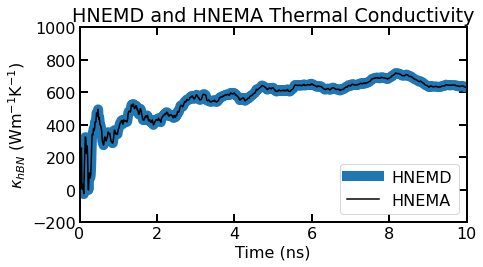

In [20]:
axes = list()
plt.figure(figsize=(7,4))
axes.append(plt.gca())
plt.plot(hnemd_t, kappa['kyi_ra']+kappa['kyo_ra'], linewidth=10,color='C0')
plt.plot(hnema_t, np.sum(kappamode['kyi_ra'], axis=0)+np.sum(kappamode['kyo_ra'], axis=0),color='k')
plt.xlim([0, 10])
plt.gca().set_xticks(range(0,11,2))
plt.ylim([-200, 1000])
plt.gca().set_yticks(range(-200,1001,200))
plt.xlabel('Time (ns)')
plt.ylabel(r'$\kappa_{hBN}$ (Wm$^{-1}$K$^{-1}$)')
set_fig_properties(axes)
plt.title('HNEMD and HNEMA Thermal Conductivity')
plt.legend(['HNEMD', 'HNEMA'], loc='lower right')
plt.tight_layout()
plt.show()

The running average of the thermal conductivity for the HNEMD and the HNEMA (summed over all modes) versus time.

- We find good agreement between the running average of the thermal conductivity of the HNEMD method and HNEMA method. This is expected but good to check to ensure that the HNEMA method and processing is working correctly.

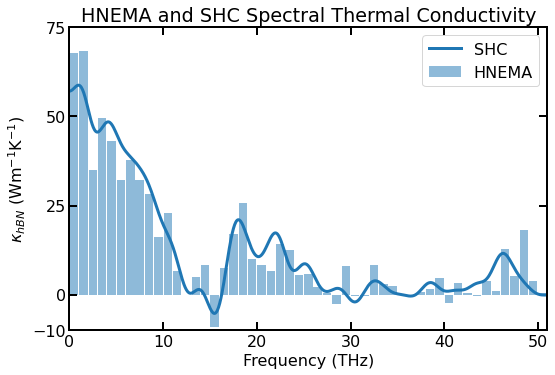

In [21]:
flow = freq['fmin'] + freq['bin_f_size']/2
fhigh = freq['fmax']-freq['bin_f_size']/2
fax = np.linspace(flow, fhigh, freq['nbins'])
w = 0.9*(fax[1]-fax[0])

plt.figure(figsize=(8,5.5))
set_fig_properties([plt.gca()])
plt.bar(fax, kappamode['kyi_ra'][:,-1]+kappamode['kyo_ra'][:,-1], w, alpha=0.5)
plt.xlim([0, freq['nbins']])
plt.ylim([-10, 75])
plt.gca().set_yticks([-10, 0, 25, 50, 75])
plt.plot(shc['nu'], shc['kw'],linewidth=3)
plt.ylabel('$\kappa_{hBN}$ (Wm$^{-1}$K$^{-1}$)')
plt.xlabel('Frequency (THz)')
plt.legend(['SHC', 'HNEMA'])
plt.title('HNEMA and SHC Spectral Thermal Conductivity')
plt.tight_layout()
plt.show()

Spectral thermal conductivity of a ~10$\times$10 nm$^2$ sheet of hBN using the SHC method (blue line) and the HNEMA method (light blue bars) for a single simulation. 

- Since both the HNEMA and SHC methods derive their thermal conductivity from the same induced heat current from the driving force, their results tend to look similar. As found in [[Gabourie 2021]](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.103.205421), both methods converge to a final spectral thermal conductivity on similar simulation timescales, although this depends on the size of the bins chosen for the HNEMA method.
- Negative values are OK and do not suggest that there is an error in the simulation/results. If you average over enough independent simulations, all modal thermal conductivities should be greater than or equal to 0 Wm$^{-1}$K$^{-1}$.

### Kappa Comparison
- We find good agreement for the total thermal conductivity across each of the HNEMD, SHC, and HNEMA methods.

In [22]:
print('HNEMD: ', np.round(kappa['kyi_ra'][-1]+kappa['kyo_ra'][-1],2), 'W/m/K')
print('SHC: ', np.round(np.trapz(shc['kw'], shc['nu']),2), 'W/m/K')
print('HNEMA: ', np.round(sum(kappamode['kyi_ra'][:,-1]+kappamode['kyo_ra'][:,-1]),2), 'W/m/K')

HNEMD:  631.88 W/m/K
SHC:  629.45 W/m/K
HNEMA:  631.82 W/m/K


## 5. GKMA Simulation
- The Green Kubo Modal Analysis (GKMA) method was originally proposed in [[Lv & Henry 2016]](https://iopscience.iop.org/article/10.1088/1367-2630/18/1/013028). The implementation for GPUMD was developed in [[Gabourie 2021]](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.103.205421).
- The [compute_hac](https://gpumd.zheyongfan.org/index.php/The_compute_hac_keyword) (Green-Kubo method) and the [compute_gkma](https://gpumd.zheyongfan.org/index.php/The_compute_gkma_keyword) can be run at the same time.

### The <code>run.in</code> file

In [23]:
# Variables we use for the simulation & processing
gkma_sample_interval = 10
gkma_num_steps = 1e7
num_runs = 3

In [24]:
gkma_sim = Simulation(hbn, driver_directory='.', run_directory=gkma_dir)
gkma_sim.add_static_calc(kwd.Minimize(force_tolerance=1e-8, max_iterations=1e4))

In [25]:
# equilibration simulation
header = "Heat Step (100 ps)"
curr_run = gkma_sim.add_run(number_of_steps=1e5, run_name='equilibration', run_header=header)

nvt_ensemble = kwd.Ensemble(ensemble_method='nvt_nhc')
nvt_ensemble.set_nvt_parameters(initial_temperature=300, final_temperature=300, thermostat_coupling=200)

keywords = [
    kwd.Velocity(initial_temperature=300),
    kwd.TimeStep(dt_in_fs=1),
    nvt_ensemble,
    kwd.NeighborOff(),
    kwd.DumpThermo(1e4)
]

for keyword in keywords:
    curr_run.add_keyword(keyword)

In [26]:
# transition to nve
header = "NVE Transition (100 ps)"
curr_run = gkma_sim.add_run(number_of_steps=1e5, run_name='transition', run_header=header)

nve_ensemble = kwd.Ensemble(ensemble_method='nve')

keywords = [
    nve_ensemble,
    kwd.NeighborOff(),
    kwd.DumpThermo(1e4)
]

for keyword in keywords:
    curr_run.add_keyword(keyword)

In [27]:
# production simulation
header = "GKMA Step (10 ns)"
curr_run = gkma_sim.add_run(number_of_steps=gkma_num_steps, run_name='production', run_header=header)

nve_ensemble = kwd.Ensemble(ensemble_method='nve')

keywords = [
    nve_ensemble,
    kwd.NeighborOff(),
    kwd.DumpThermo(1e4),
    kwd.ComputeHAC(sample_interval=gkma_sample_interval, num_corr_steps=1e5, output_interval=1),
    kwd.ComputeGKMA(sample_interval=10, first_mode=1, last_mode=len(hbn)*3, \
                    bin_option='f_bin_size', size=1)    
]

for keyword in keywords:
    curr_run.add_keyword(keyword)

In [28]:
potential_directory = "/path/to/GPUMD/potentials/tersoff"
tersoff_potential = \
    kwd.Potential(filename='BN_Sevik_2011.txt', symbols=['B'], directory=potential_directory)
gkma_sim.add_potential(tersoff_potential)

In [29]:
# Generate several different runs easilty using the gpyumd simulation object
for run_num in range(num_runs):
    gkma_sim.set_directory(run_directory=os.path.join(gkma_dir, f'run{run_num}'))
    gkma_sim.create_simulation(copy_potentials=True)

- As Green-Kubo thermal conductivity calculations generally require many independent runs averaged together, we choose to run 3 independent simulations here to improve our results. Note that we can use the same Simulation object to write to many different folders to easily facilitate the setup.
- **Note**: the `eigenvector.in` must be separately copied into each of the run directories. Since this file can be very large, we do not move/copy it automatically and leave that behavior up to the user's preferences/needs.

The `run.in` input file is given below:
```
potential gkma/run0/BN_Sevik_2011.txt 0

minimize sd 1e-08 10000 

# Heat Step (100 ps)
velocity 300 
time_step 1 
ensemble nvt_nhc 300 300 200 
neighbor off 
dump_thermo 10000 
run 100000 

# NVE Transition (100 ps)
ensemble nve 
neighbor off 
dump_thermo 10000 
run 100000 

# GKMA Step (10 ns)
ensemble nve 
neighbor off 
dump_thermo 10000 
compute_hac 10 100000 1 
compute_gkma 10 1 11520 f_bin_size 1 
run 10000000 
```

- All lines up through the first [run](https://gpumd.zheyongfan.org/index.php/The_run_keyword) are the same as in the HNEMA simulation. The first [run](https://gpumd.zheyongfan.org/index.php/The_run_keyword) is to equilibrate the system.

- The second [run](https://gpumd.zheyongfan.org/index.php/The_run_keyword) serves as a transition stage, where the NVE [ensemble](https://gpumd.zheyongfan.org/index.php/The_ensemble_keyword) is used for a short 100 ps to let any effects from the thermostat dissipate. There are $10^5$ steps (100 ps) for this [run](https://gpumd.zheyongfan.org/index.php/The_run_keyword) and the thermodynamic quantities will be output every 10000 steps.

- The final [run](https://gpumd.zheyongfan.org/index.php/The_run_keyword) is for production. Here, the NVE [ensemble](https://gpumd.zheyongfan.org/index.php/The_ensemble_keyword) is used. The line with the [compute_hac](https://gpumd.zheyongfan.org/index.php/The_compute_hac_keyword) keyword means that heat currents will be recorded every 10 steps (10 fs), 100000 HAC data (the maximum correlation time is then about 1 ns) will be calculated, and the HAC are averaged for every 1 data points before written out. The production time is 10 ns ($10^7$ steps), which is 10 times as long as the maximum correlation time. This is a reasonable choice. The line with the [compute_gkma](https://gpumd.zheyongfan.org/index.php/The_compute_gkma_keyword) keyword in it tells us that we want to calculate the modal heat current with the GKMA method, that the modal heat flux will be sampled every 10 steps, that the vibrational mode we will start with is the first and we will include all modes until mode 11520 (i.e., the last mode of a 3N=3$\times$3840 atom hBN sheet), and that we want to bin by frequency with a bin size of 1 THz.
  

### Results and Discussion

#### Computation Time
- The GKMA simulation takes about ~35 minutes using a Tesla V100. The GKMA simulation is faster because the method only outputs heat current (i.e., does not directly compute thermal conductivity) and the GKMA sample rate is every 10 steps instead of 8 steps used for the HNEMA method.

#### Process Green-Kubo Results
- We load and process the results from the [hac.out](https://gpumd.zheyongfan.org/index.php/The_hac.out_output_file) output file. We do this to validate that our set of equilibrium simulations is sufficient to yield reasonable results and to ensure that our GKMA calculations are working properly by this data to the GKMA results.
- We also choose the range of correlation times we wish to average over to get a 'converged' thermal conductivity. Based on the figure below, we chose to average over the [300 ps, 400 ps] range of correlation times. This will also be used for the GKMA analysis.

In [30]:
tau_range = range(30000,40000)  # 300 ps to 400 ps correlation time

In [31]:
hac_dict = dict()
for run_num in range(num_runs):
    hac_dict[f'run{run_num}'] = load_hac(num_corr_points=100000, output_interval=1, directory=os.path.join(gkma_dir,f"run{run_num}"))['run0']

In [32]:
# Average over each of the 3 runs
gk_tau = hac_dict['run0']['t']
ki_ave, ko_ave = np.zeros_like(hac_dict['run0']['kxi']), np.zeros_like(hac_dict['run0']['kxi'])
for runkey in hac_dict.keys():
    ki_ave += (hac_dict[runkey]['kxi']+hac_dict[runkey]['kyi'])
    ko_ave += (hac_dict[runkey]['kxo']+hac_dict[runkey]['kyo'])
ki_ave /= (2*len(hac_dict))
ko_ave /= (2*len(hac_dict))

kappa_gk = np.mean((ki_ave+ko_ave)[tau_range])  # Our total GK thermal conductivity 

#### Plot GKMA Results
- We load and process the [heatmode.out](https://gpumd.zheyongfan.org/index.php/The_heatmode.out_output_file) output file with the `load_heatmode` function from [gpyumd](https://github.com/AlexGabourie/gpyumd). 
- The [heatmode.out](https://gpumd.zheyongfan.org/index.php/The_heatmode.out_output_file) files can be very large and this function can take much more time and resources than others in [gpyumd](https://github.com/AlexGabourie/gpyumd). To save resources, users can choose which directions to process. Here, we use the `directions` parameter to define which data we want to keep. We have chosen $x$ and $y$ data meaning that the $z$ data is thrown out.
- It is also useful to save the data by setting <code>save=True</code>. This will save the processed results into a numpy binary which is much more space efficient and faster to load (no text processing). Once a numpy binary is saved, the user may delete their [heatmode.out](https://gpumd.zheyongfan.org/index.php/The_heatmode.out_output_file) file.
- Finally, we are mainly saving the data as a binary here and ask `load_heatmode` to not return the dictionary to save memory.

In [33]:
# Save the data to disk in binary format. Can delete heatmode.out files after.
for run_num in range(num_runs):
    if not os.path.exists(os.path.join(gkma_dir, f"run{run_num}", "heatmode.npy")):
        load_heatmode(nbins=freq['nbins'], nsamples=int(gkma_num_steps/gkma_sample_interval), \
                      directory=os.path.join(gkma_dir, f"run{run_num}"), directions='xy', save=True, \
                      return_data=False)

- The [heatmode.out](https://gpumd.zheyongfan.org/index.php/The_heatmode.out_output_file) file only has modal heat current data. We must also calculate the running modal thermal conductivity. For that, [gpyumd](https://github.com/AlexGabourie/gpyumd) has the `calc_gkma_kappa` function. This function will add the results of the calculations to the data dictionary passed to it. Here, since we know that we will average over the correlation time up to 400 ps, we choose a `max_tau` of 0.5 ns for our modal running thermal conductivity calculations. We also choose to save the data to a numpy binary like before so we do not have to repeat any processing.

In [34]:
kappa_gkma_bins = np.zeros(freq['nbins'])
gkma_total_rtc = None
gkma_tau = None

for run_num in range(num_runs):
    heatmode = load_saved_heatmode(directory=os.path.join(gkma_dir, f"run{run_num}"))
    # Don't recalculate if already done
    if 'tau' not in heatmode.keys():
        calc_gkma_kappa(data=heatmode, dt=1, sample_interval=gkma_sample_interval, temperature=300, 
                        vol=np.prod(hbn.cell.lengths()), max_tau=0.5, directions='xy', save=True, 
                        directory=os.path.join(gkma_dir, f"run{run_num}"))

    # Calculate running thermal conductivity
    if gkma_total_rtc is None:
        gkma_tau = heatmode['tau']
        gkma_total_rtc = (np.sum(heatmode['kmyi'], axis=0) + np.sum(heatmode['kmyo'], axis=0) + 
         np.sum(heatmode['kmxi'], axis=0) + np.sum(heatmode['kmxo'], axis=0))/(2*num_runs)
    else:
        gkma_total_rtc += (np.sum(heatmode['kmyi'], axis=0) + np.sum(heatmode['kmyo'], axis=0) + 
         np.sum(heatmode['kmxi'], axis=0) + np.sum(heatmode['kmxo'], axis=0))/(2*num_runs)
    
    # Find average thermal conductivity for a bin and take only that data from 'heatmode' object.
    for bin_num in range(freq['nbins']):
        kappa_gkma_bins[bin_num] += np.mean((heatmode['kmxi'][bin_num,:]+heatmode['kmyi'][bin_num,:]+  
                                             heatmode['kmxo'][bin_num,:]+heatmode['kmyo'][bin_num,:])[tau_range])/(2*num_runs)  
    del heatmode  # Save memory

We delete the `heatmode` dictionary here to save memory, but, if we kept it, it would have the following keys:

dict_keys(['jmxi', 'jmxo', 'jmyi', 'jmyo', 'nbins', 'nsamples', 'tau', 'jmxijx', 'jmxojx', 'kmxi', 'kmxo', 'jmyijy', 'jmyojy', 'kmyi', 'kmyo'])

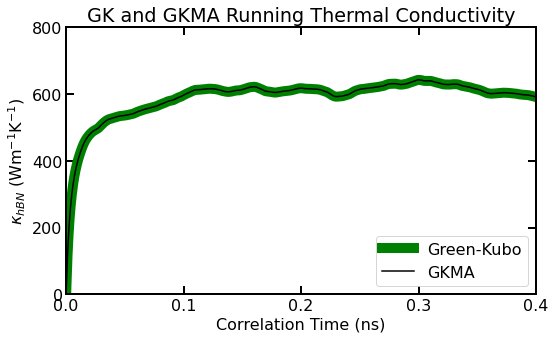

In [35]:
axes = list()
plt.figure(figsize=(8,5))
axes.append(plt.gca())
plt.plot(gk_tau/1000, ki_ave + ko_ave, color='g', linewidth=10)
plt.plot(gkma_tau, gkma_total_rtc, color='k')
plt.xlim([0, 0.4])
plt.gca().set_xticks(np.arange(0,401,100)/1000)
plt.ylim([0, 800])
plt.gca().set_yticks(range(-0,801,200))
plt.xlabel('Correlation Time (ns)')
plt.ylabel(r'$\kappa_{hBN}$ (Wm$^{-1}$K$^{-1}$)')
set_fig_properties(axes)
plt.title('GK and GKMA Running Thermal Conductivity')
plt.legend(['Green-Kubo', 'GKMA'], loc='lower right')
plt.tight_layout()
plt.show()

Averaged total running thermal conductivity as a function of correlation time for the Green-Kubo method (green line) and the GKMA method (black line).

- For equilibrium simulations on structures that have isotropic thermal conductivity, we can combine results from different directions for better statistics. Here, we have isotropic in-plane thermal conductivity, so we average the $x$ and $y$ direction data, effectively 'doubling' the amount of data used to calculate our results.
- We find good agreement between the running thermal conductivity of the GK method and GKMA method. This is expected but good to check to ensure that the GKMA method and processing is working correctly.

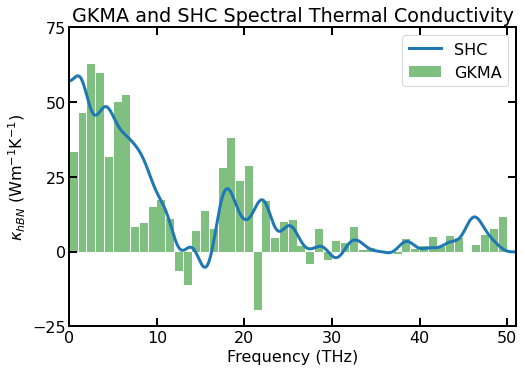

In [36]:
flow = freq['fmin'] + freq['bin_f_size']/2
fhigh = freq['fmax']-freq['bin_f_size']/2
fax = np.linspace(flow, fhigh, freq['nbins'])
w = 0.9*(fax[1]-fax[0])

plt.figure(figsize=(8,5.5))
set_fig_properties([plt.gca()])
plt.bar(fax, kappa_gkma_bins, w, alpha=0.5, color='g')
plt.xlim([0, freq['nbins']])
plt.ylim([-25, 75])
plt.gca().set_yticks([-25, 0, 25, 50, 75])
plt.plot(shc['nu'], shc['kw'],linewidth=3)
plt.ylabel('$\kappa_{hBN}$ (Wm$^{-1}$K$^{-1}$)')
plt.xlabel('Frequency (THz)')
plt.title('GKMA and SHC Spectral Thermal Conductivity')
plt.legend(['SHC', 'GKMA'])
plt.show()

Spectral thermal conductivity of a ~10$\times$10 nm$^2$ sheet of hBN using the SHC method (blue line) and the GKMA method (light green bars) for a single simulation. 

- The GKMA spectral thermal conductivity is qualitatively similar to the SHC method's but does not match as well as the HNEMA method. In general, all three methods (GKMA, HNEMA, and SHC) trend towards the same spectral thermal conductivity as the number of independent simulations increase, but the GKMA method will converge much slower and have significantly higher uncertainty [[Gabourie 2021]](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.103.205421). In the figure above, it is likely (although not proven) that the SHC spectral thermal conductivity is closer to 'final' than the GKMA spectral thermal conductivity even though the GKMA method results are from 3 independent simulations (and 6$\times$ the data as we average the $x$ and $y$ directions).

### Kappa Comparison
- We find good agreement for the total thermal conductivity across each of the HNEMD, SHC, and HNEMA methods.
- The total thermal conductivity of the GK and GKMA methods match.
- Many more independent simulations must be run for the GKMA and HNEMA methods to converge to a final thermal conductivity. With error bars, these converged thermal conductivities are typically comparable.

In [37]:
print('HNEMD: ', np.round(kappa['kyi_ra'][-1]+kappa['kyo_ra'][-1],2), 'W/m/K')
print('SHC: ', np.round(np.trapz(shc['kw'], shc['nu']),2), 'W/m/K')
print('HNEMA: ', np.round(sum(kappamode['kyi_ra'][:,-1]+kappamode['kyo_ra'][:,-1]),2), 'W/m/K')
print('GK: ', np.round(kappa_gk, 2),'W/m/K')
print('GKMA: ', np.round(sum(kappa_gkma_bins),2), 'W/m/K')

HNEMD:  631.88 W/m/K
SHC:  629.45 W/m/K
HNEMA:  631.82 W/m/K
GK:  615.93 W/m/K
GKMA:  616.13 W/m/K


## 6. References

- [Tersoff 1989] J. Tersoff, [Modeling solid-state chemistry: Interatomic potentials for multicomponent systems](https://doi.org/10.1103/PhysRevB.39.5566), Phys. Rev. B 39, 5566(R) (1989).
- [Sevik 2011] C. Sevik, A. Kinaci, J.B. Haskins, and T. Cagin, [Characterization of thermal transport in low-dimensional boron nitride nanostructures](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.84.085409), Phys. Rev. B 84, 085409 (2011).
- [Gabourie 2021] A.J. Gabourie, Z. Fan, T. Ala-Nissila, and E. Pop [Spectral decomposition of thermal conductivity: Comparing velocity decomposition methods in homogeneous molecular dynamics simulations](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.103.205421), Phys. Rev. B 103, 205421 (2021).
- [Fan 2019] Z. Fan, H. Dong, A. Harju, and T. Ala-Nissila, [Homogeneous nonequilibrium molecular dynamics method for heat transport and spectral decomposition with many-body potentials](https://doi.org/10.1103/PhysRevB.99.064308), Phys. Rev. B **99**, 064308 (2019).
- [Lv & Henry 2016] W. Lv and A. Henry [Direct calculation of modal contributions to thermal conductivity via Green–Kubo modal analysis](https://iopscience.iop.org/article/10.1088/1367-2630/18/1/013028), New J. Phys., 18, 013028 (2016).